***
#### 1) Just Run to set up libraries and verify Stan exists

In [ ]:
# install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
library(cmdstanr)
library(posterior)
set_cmdstan_path('/opt/conda/bin/cmdstan')
cmdstan_version()

***
####  2) Create subfolder in Projects directory and import rds data file there 
Then specify in first two lines:  
><code style="color:yellow">dir_work</code> is directory you created for output and typically data  
><code style="color:yellow">my_rds_data</code> has name of rds data.  Typically this is in dir_work above   
><code style="color:yellow">out_prefix</code> alphanumeric descriptive prefix for all output files (e.g. a project code).  No "/", special symbols   
Advanced users can also use my_stan_code to specify a Stan file in the StanCode folder

In [71]:
################    REQUIRED ENTRIES       #####################
dir_work <- "/home/sagemaker-user/Projects/KevProject1" # NAME OF FOLDER FOR OUTPUT FILES
my_rds_data <- file.path(dir_work, "data_conjoint.rds") # NAME OF RDS FILE (usually in dir_work, but you can specify where)
out_prefix <- "12 3 4" # Prefix for output files (descriptive string no /)

################    OPTIONAL       #####################
my_stan_code <- "MNL_BartBlockCon_v1_7.stan" # OPtional: Specify other stan model here in subfolder StanCode
dir_stan <- "/home/sagemaker-user/StanCode" # Typically any Stan code will be put in here

################ LEAVE BELOW ALONE #####################
if (!file.exists(file.path(my_rds_data))){
  message(paste0("Cannot find your data file: ", my_rds_data))    
} else {
  data_stan <- readRDS(file.path(my_rds_data))
  message("Working directory for output set to: ", dir_work)
  message("Read data into R RAM file data_stan:")
  str(data_stan)  
}
if (!file.exists(file.path(dir_stan, my_stan_code))){
  message(paste0("Cannot find Stan Code in: ", dir_stan))    
} else {
  cat("Compiling Stan code...")  
  HB_model <- cmdstan_model(file.path(dir_stan,my_stan_code), quiet = TRUE, cpp_options = list(stan_threads = TRUE))
  cat("DONE")
}

Working directory for output set to: /home/sagemaker-user/Projects/KevProject1

Read data into R RAM file data_stan:



List of 18
 $ tag            : chr "Sawtooth Prize"
 $ N              : int 28800
 $ P              : int 21
 $ T              : int 7200
 $ I              : int 600
 $ dep            : Named num [1:28800] 0 1 0 0 1 0 0 0 1 0 ...
  ..- attr(*, "names")= chr [1:28800] "1" "1" "1" "1" ...
 $ ind            : num [1:28800, 1:21] 0 0 0 1 -1 0 -1 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:21] "Att.1...Destination._1" "Att.1...Destination._2" "Att.1...Destination._3" "Att.1...Destination._4" ...
 $ idtask         :'data.frame':	28800 obs. of  2 variables:
  ..$ CaseID: int [1:28800] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ Task  : int [1:28800] 1 1 1 1 2 2 2 2 3 3 ...
 $ idtask_r       : int [1:28800] 1 1 1 1 2 2 2 2 3 3 ...
 $ resp_id        : int [1:600] 1 3 5 6 7 9 10 12 14 16 ...
 $ match_id       : int [1:28800] 1 1 1 1 1 1 1 1 1 1 ...
 $ task_individual: int [1:7200] 1 1 1 1 1 1 1 1 1 1 ...
 $ start          : int [1:7200] 1 5 9 13 17 21 25 29 33 37 ...
 $ end

***
#### 3) Specify constraints

In [ ]:
# Specify constraints (sign only)
# For each parameter: 0 = no constraint, +1 = positive, -1 = negative
con_sign <- rep(0,data_stan$P)
con_sign[18:21] <- -1 # Negative utilities for price slopes

***  
#### 4) Specify threads and modeling specs

In [72]:
# Specify threads
threads <- list(tot_chains = 2, # Typically 2
                parallel_chains = 2, # Typically 2
                threads_per_chain = 1) # Depends on Cores, 8 to 16 is desirable

# Modeling parameters. Defaults are usually fine
data_model <- list(
  iter_warmup = 300, # warmup of 400 is plenty
  iter_sampling = 300, # sampling of 400 is plenty 
  con_sign = con_sign,
  prior_cov = data_stan$prior_cov * 1, # Change cov scale here  
  df = 2, # Degrees of freedom
  prior_alpha = rep(0, data_stan$P),
  a_sig = 10,
  cov_block = matrix(1, data_stan$P, data_stan$P),
  splitsize = round(.5 + data_stan$T/(4 * threads[[2]])),
  agg_model = NULL,
  tag = NULL
)
message("Modeling specs: ")
str(modifyList(threads,data_model))
message("All Prep is Done")

Modeling specs: 



List of 12
 $ tot_chains       : num 2
 $ parallel_chains  : num 2
 $ threads_per_chain: num 1
 $ iter_warmup      : num 300
 $ iter_sampling    : num 300
 $ con_sign         : num [1:21] 0 0 0 0 0 0 0 0 0 0 ...
 $ prior_cov        : num [1:21, 1:21] 0.833 -0.167 -0.167 -0.167 -0.167 ...
 $ df               : num 2
 $ prior_alpha      : num [1:21] 0 0 0 0 0 0 0 0 0 0 ...
 $ a_sig            : num 10
 $ cov_block        : num [1:21, 1:21] 1 1 1 1 1 1 1 1 1 1 ...
 $ splitsize        : num 900


All Prep is Done



***
#### Rest of code can just be run  
**-- Estimate Model --**


ESTIMATING...



Optional lines to run in terminal to check progress:
cd /home/sagemaker-user/Projects/KevProject1   # Change to your working directory and then:
  awk 'END { print NR - 45 } ' 12 3 4_StanOut_20211007-202755-1.csv                # Count lines in output
  tail -n +45 12 3 4_StanOut_20211007-202755-1.csv  | cut -d, -f 1-300 > temp.csv  # Create temp.csv with first 300 columns
Running MCMC with 2 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 600 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 600 [  0%]  (Warmup) 
Chain 2 Iteration:  50 / 600 [  8%]  (Warmup) 
Chain 1 Iteration:  50 / 600 [  8%]  (Warmup) 
Chain 1 Iteration: 100 / 600 [ 16%]  (Warmup) 
Chain 2 Iteration: 100 / 600 [ 16%]  (Warmup) 
Chain 1 Iteration: 150 / 600 [ 25%]  (Warmup) 
Chain 1 Iteration: 200 / 600 [ 33%]  (Warmup) 
Chain 1 Iteration: 250 / 600 [ 41%]  (Warmup) 
Chain 1 Iteration: 300 / 600 [ 50%]  (Warmup) 
Chain 1 Iteration: 301 / 600 [ 50%]  (Sampling) 
Chain 1 Iteration: 350 / 600 [ 58%]  

 variable      mean    median    sd   mad        q5       q95 rhat ess_bulk
 lp__     -11025.05 -11020.80 97.87 98.89 -11181.91 -10879.98 1.03      173
 alpha[1]     -0.48     -0.48  0.07  0.08     -0.60     -0.37 1.00      519
 alpha[2]      0.42      0.41  0.08  0.07      0.30      0.55 1.00      350
 alpha[3]      0.44      0.45  0.08  0.08      0.31      0.57 1.01      517
 alpha[4]      0.16      0.17  0.09  0.09      0.02      0.30 1.00      504
 alpha[5]     -0.47     -0.46  0.09  0.09     -0.62     -0.32 1.00      355
 alpha[6]      0.01      0.01  0.06  0.06     -0.08      0.10 1.00      635
 alpha[7]     -0.04     -0.04  0.07  0.07     -0.15      0.06 1.00      676
 alpha[8]      0.20      0.20  0.05  0.05      0.11      0.29 1.00      760
 alpha[9]      0.14      0.14  0.05  0.05      0.05      0.22 1.00      614
 ess_tail
      209
      470
      389
      511
      444
      523
      557
      472
      548
      511

 # showing 10 of 25453 rows (change via 'max_rows' ar

### ESTIMATION DONE ###. 
Reading draws from Stan csv output into R (large files take time)...DONE

Saving:
 draws of utilities as R list:  12 3 4_draws_beta.rds
 respondent point estimates:    12 3 4_utilities_r.csv
 convergence stats of mean:     12 3 4_fit_stats.csv
 PDF of detailed traceplots:    12 3 4_trace_plots.pdf

Showing:
 Acceptance rate of sampling draws
 Traceplots of all mean utilities together (Sawtooth chart)



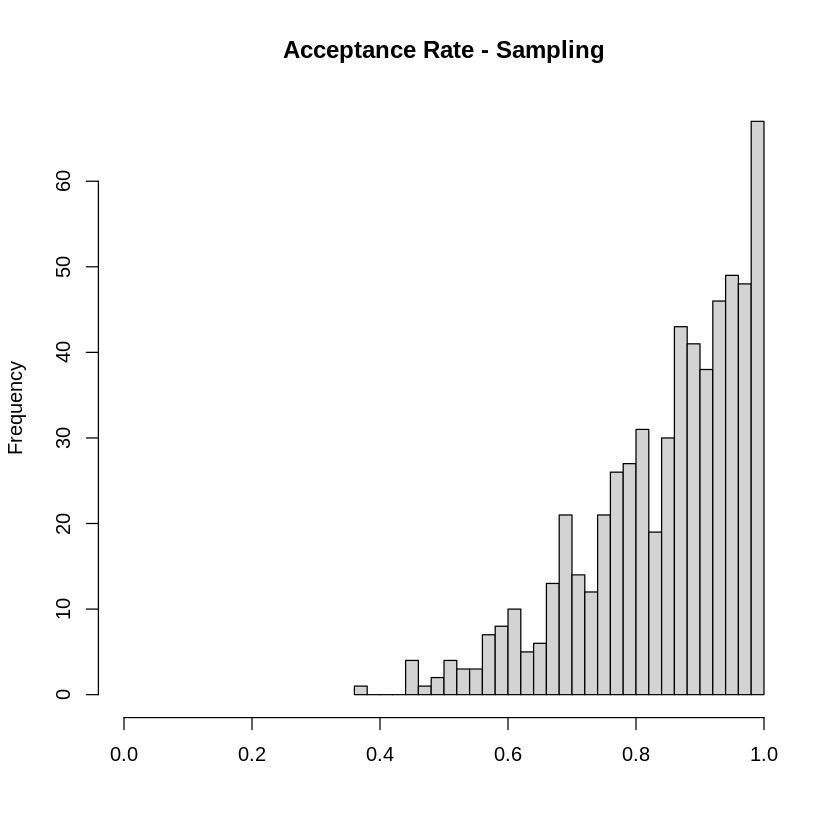

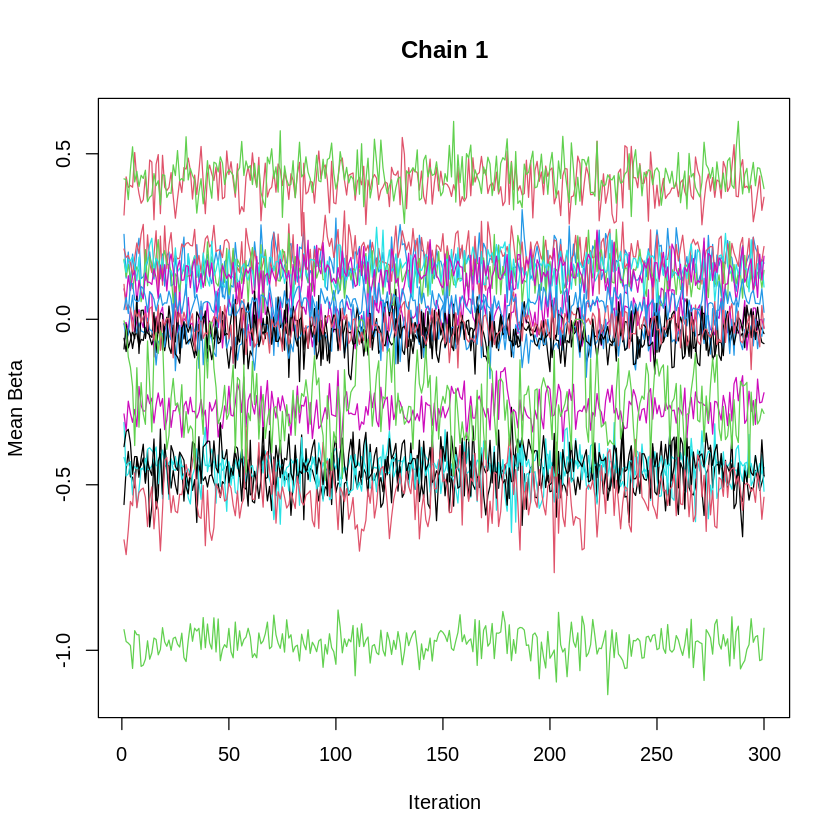

png 
  2

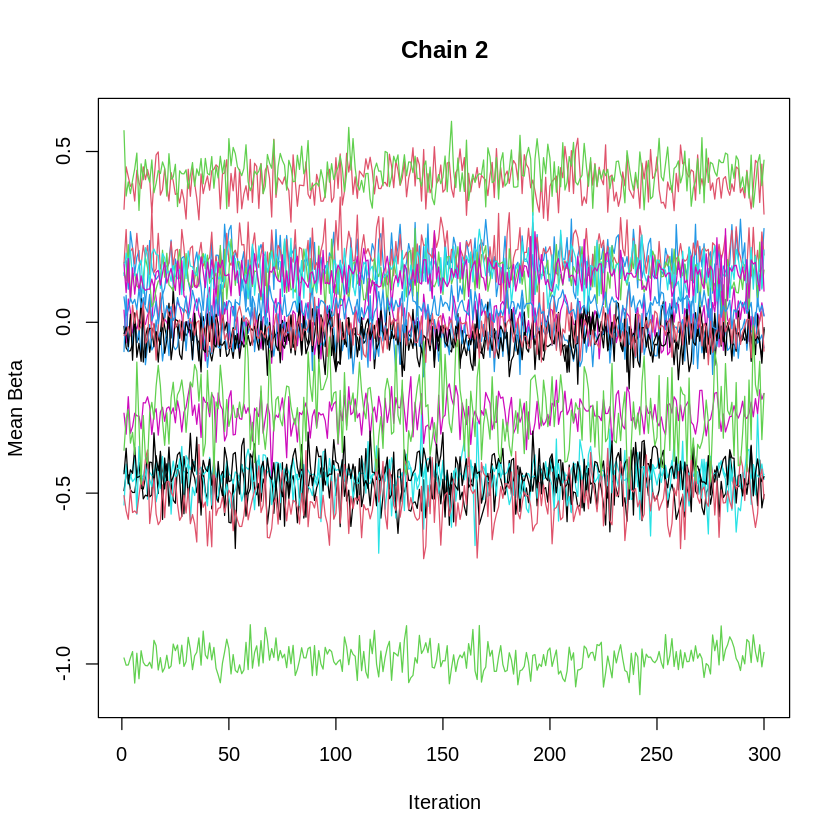

In [73]:
outname <- paste0(out_prefix, "_StanOut_", 
                  format(Sys.time(), '%Y%m%d-%H%M%S')) # edit as desired
message("ESTIMATING...")
cat("Optional lines to run in terminal to check progress:\n")
cat(paste0(
    "cd ", dir_work, "   # Change to your working directory and then:\n",
    "  awk 'END { print NR - 45 } ' ",outname,"-1.csv", "                # Count lines in output\n",
    "  tail -n +45 ",outname,"-1.csv  | cut -d, -f 1-300 > temp.csv", "  # Create temp.csv with first 300 columns\n"))

#####  Run Stan Model ###############
HB_model$sample(modifyList(data_stan, data_model),
                iter_warmup = data_model$iter_warmup,
                iter_sampling = data_model$iter_sampling,
                output_dir = dir_work,
                output_basename = outname,
                chains = threads[[1]],
                parallel_chains = threads[[2]],
                threads_per_chain = threads[[3]],
                save_warmup = TRUE,
                refresh = 50,
                seed = 271,
                init = .1,
                adapt_delta = .8,
                show_messages = FALSE,
                validate_csv = FALSE
)

###############   Save Results and Evaluate Convergence ##################
cat("### ESTIMATION DONE ###. \nReading draws from Stan csv output into R (large files take time)...")
nchains <- threads[[1]]
csv_name <- do.call(c, lapply(1:nchains, function(i) paste0(outname,"-",i,".csv")))
draws_beta <- read_cmdstan_csv(file.path(dir_work, csv_name), variables = "beta_ind", format = "draws_list", sampler_diagnostics = "accept_stat__")
cat("DONE")
draws_name <- paste0(out_prefix,"_draws_beta.rds")
util_name <- paste0(out_prefix,"_utilities_r.csv")
pdf_name <- paste0(out_prefix,"_trace_plots.pdf")
fit_name <-  paste0(out_prefix,"_fit_stats.csv")
message(paste0(
  "Saving:\n",
  " draws of utilities as R list:  ", draws_name,"\n",
  " respondent point estimates:    ", util_name,"\n",
  " convergence stats of mean:     ", fit_name, "\n",
  " PDF of detailed traceplots:    ", pdf_name,"\n",
  "\nShowing:\n",
    " Acceptance rate across sampling iterations\n",
    " Traceplots of all mean utilities together (Sawtooth chart)"
))

hist(do.call(rbind,draws_beta$post_warmup_sampler_diagnostics)$accept_stat__, breaks = 30, main = "Acceptance Rate - Sampling", xlab = "", xlim = c(0,1))
saveRDS(modifyList(draws_beta,list(warmup_draws = NULL)), file.path(dir_work, draws_name)) # drop warmup
utilities <- matrix(
            Reduce("+",lapply(draws_beta$post_warmup_draws, colMeans))/nchains,
            data_stan$I, data_stan$P,
            byrow = TRUE) # First P entries are respondent 1, next P are resp 2
utilities_r <- utilities %*% t(data_stan$code_master)
write.table(cbind(id = data_stan$resp_id, utilities_r), file = file.path(dir_work, util_name), sep = ",", na = ".", row.names = FALSE)
                              
# Convergence charts saved as pdf and in fit_stats
fit_stats <- data.frame(
  variable = colnames(data_stan$ind),
  mean = NA,
  rhat = NA,
  ESS = NA
)
ndraws <- nrow(draws_beta$post_warmup_draws[[1]])
draws_beta_mu <- list() # Creates the mean of respondent utilities for each iteration, like alpha
for (chain_i in (1:nchains)){
  draws_beta_list <- as.matrix(draws_beta$post_warmup_draws[[chain_i]])
  draws_beta_mu[[chain_i]] <- t(sapply(1:ndraws, function(draw){
    beta_mu <- colMeans(matrix(draws_beta_list[draw,],
                               data_stan$I,data_stan$P, byrow = TRUE))
  }))
  matplot(1:nrow(draws_beta_mu[[chain_i]]), draws_beta_mu[[chain_i]],
          type = "l" , lty = 1, lwd = 1, main = paste0("Chain ", chain_i), xlab = "Iteration", ylab = "Mean Beta")   
} 
chain_cols <- c("red","blue","green","black")
pdf(file = file.path(dir_work, pdf_name),   # The directory you want to save the file in
    width = 7, # The width of the plot in inches
    height = 5) # The height of the plot in inches
for (i in 1:ncol(draws_beta_mu[[1]])){
  x <- sapply(1:length(draws_beta_mu), function(chain){
    draws_beta_mu[[chain]][,i]     
  }) # x is set of column i across draws_beta_mu
  fit_stats$mean[i] <- round(mean(x), 2)
  fit_stats$rhat[i] <- round(rhat(x),2)
  fit_stats$ESS[i] <- round(ess_basic(x),1)

  plot(x[,1], type = "l", col = chain_cols[1], ylim = c(min(x), max(x)),
                          xlab = "Sample Iteration", ylab = "Mean Beta",
                          main = paste(colnames(data_stan$ind)[i],
                                                    "| rhat = ", round(rhat(x),2),
                                                    "| ESS = ", round(ess_basic(x),1)
  ))
  for (chain in 2:nchains){
    lines(x[,2], type = "l", col = chain_cols[chain])
  }
}
dev.off()
write.table(fit_stats, file = file.path(dir_work, paste0(out_prefix,"_fit_stats.csv")), sep = ",", na = ".", row.names = FALSE)